In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from qutip import *
from scipy.optimize import minimize
import h5py
import scipy as sc
from os import walk
erf = sc.special.erf
start_time = time.time()#checking how long the code takes

AL = np.linspace(-2,2,20)#final_disps#the displacements

### Simulations
T1 = 84e-6  #in s
T2 = 21e-6  #in s
Tphi = - 1/(1/2/T1 - 1/T2)
cavT1 = 1.21e-3  #in s
nbar_cav = 0
nbar_qb = 0

qdim = 2
q = destroy(qdim)
qd = create(qdim)
ug = basis(qdim,0)
ue = basis(qdim,1)

chi = 1.359e6  #in Hz
Kerr = 6e3  #in Hz
cdim = 30

Q = tensor(destroy(qdim), qeye(cdim))
C = tensor(qeye(qdim), destroy(cdim))

Cd, Qd = C.dag(), Q.dag()

# Contains information about the (pulse amplitude, pulse sigma, pulse chop)
calibration = [
    (1, 250e-9, 4),#tuple
]

A, sigma, chop = calibration[0]

matrix_elements = None
peak_heights = None
num_split_plot = None

freq_detune = -np.arange(0,11)*chi

if 1:
    '''
    Power Rabi: Use this to calibrate the amplitude needed to drive a qubit pi pulse
    '''
    amp = np.linspace(0, 1.5, 199)
    output = []

    for Ax in amp:
        A = np.sqrt(2/np.pi) / erf(np.sqrt(2))*np.pi/(4*sigma)/2/np.pi#initial guess
        A0 = A#keep it for later

        frq = 0#resonant driving

        A *= Ax#coefficient for the Gaussian pulse

        H0 = 2*np.pi*frq * qd*q
        Hd = 2*np.pi*A*1j*(qd - q)#or with other part 
        # Hd = 2*np.pi*A*(qd + q)

        def pulse(t, *arg):
            global sigma, chop
            t0 = sigma*chop/2

            g = np.exp( - 1/2 * (t - t0)**2 / sigma**2)

            return g

        H = [H0, [Hd, pulse]]

        #initial state
        # psi = basis(2, 0)
        rhoq = thermal_dm(qdim, nbar_qb)#ket2dm(psi)

        tlist = np.linspace(0, sigma*chop, 101)

        c_ops = [
            np.sqrt((1 + nbar_qb)/T1)*q,
            np.sqrt(nbar_qb/T1) * qd,
            np.sqrt(2/Tphi)*qd*q#changed
        ]

        e_ops = [qd*q,]

        # options = Options(max_step = 1, nsteps = 1e6)

        results = mesolve(H, rhoq, tlist, c_ops= c_ops, e_ops = e_ops)#, options= options)#, progress_bar = True)

        output += [results.expect[0][-1],]
    
    # plt.plot(amp, output)
    # plt.ylabel(r"pe")
    # plt.xlabel("Amplitude Scale")
    # plt.title("Power Rabi")
    # plt.grid()
    # plt.show()

    # print(max(output), output.index(max(output)), amp[output.index(max(output))])
    A = A0*amp[output.index(max(output))]#this is the correct coeff





In [2]:
print(A)

417959.5502351346


In [3]:
#new jump ops
c_ops = [
    # Qubit Relaxation
    np.sqrt((1 + nbar_qb)/T1) * Q,
    # Qubit Thermal Excitations
    np.sqrt(nbar_qb/T1) * Qd,
    # Qubit Dephasing, changed
    np.sqrt(2/Tphi)*Qd*Q,
    # Cavity Relaxation
    np.sqrt((1 + nbar_cav)/cavT1) * C,
    # Cavity Thermal Excitations
    np.sqrt(nbar_cav/cavT1) * Cd,
]

def pns_sim(RHO_tar,frq):
        # frq = freq_detune[kk]
        H0 = -2*np.pi*frq * Qd*Q - 2*np.pi*chi*Qd*Q*Cd*C - 2*np.pi*Kerr/2*Cd*Cd*C*C
        Hd = 2*np.pi*1j*(Qd - Q)
        # Hd = 2*np.pi*(Qd + Q)

        def pulse(t, *arg):
            t0 = sigma*chop/2
            g = A*np.exp( - 1/2 * (t - t0)**2 / sigma**2)

            return g

        H = [H0, [Hd, pulse]]

        e_ops = [Qd*Q,]

        # options = Options(max_step = 4, nsteps = 1e6)
        results = mesolve(H, RHO_tar, tlist, c_ops= c_ops, e_ops = e_ops)#, options = options)#, progress_bar = True)

        return results.expect[0][-1].real

In [4]:
freq_detune

array([        0.,  -1359000.,  -2718000.,  -4077000.,  -5436000.,
        -6795000.,  -8154000.,  -9513000., -10872000., -12231000.,
       -13590000.])

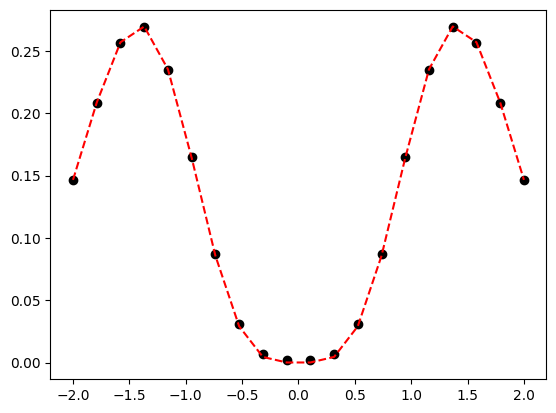

In [5]:
pns = np.zeros(len(AL))
pns_id = np.zeros(len(AL))
#The PNS simulation
RHO_tar0 = tensor(thermal_dm(qdim,nbar_qb), thermal_dm(cdim,nbar_cav))
w=0
for v1 in range(len(AL)):
    RHO_tar = tensor(qeye(qdim),displace(cdim, -AL[w]))*RHO_tar0*tensor(qeye(qdim),displace(cdim, AL[w]))
    pns[w] = pns_sim(RHO_tar,freq_detune[2])
    pns_id[w] = RHO_tar.ptrace(1)[2,2].real
    w += 1
# for v2 in np.arange(TM2):
#     RHO_tar = tensor(qeye(qdim),displace(cdim, -AL[w]))*RHO_tar0*tensor(qeye(qdim),displace(cdim, AL[w]))
#     Pid[w] = pns_sim(RHO_tar,freq_detune[2])
#     Pidid[w] = RHO_tar.ptrace(1)[2,2].real
#     w += 1
# for v3 in np.arange(TM3):
#     RHO_tar = tensor(qeye(qdim),displace(cdim, -AL[w]))*RHO_tar0*tensor(qeye(qdim),displace(cdim, AL[w]))
#     Pid[w] = pns_sim(RHO_tar,freq_detune[3])
#     Pidid[w] = RHO_tar.ptrace(1)[3,3].real
#     w += 1
# for v4 in np.arange(TM4):
#     RHO_tar = tensor(qeye(qdim),displace(cdim, -AL[w]))*RHO_tar0*tensor(qeye(qdim),displace(cdim, AL[w]))
#     Pid[w] = pns_sim(RHO_tar,freq_detune[4])
#     Pidid[w] = RHO_tar.ptrace(1)[4,4].real
#     w += 1
# for v5 in np.arange(TM5):
#     RHO_tar = tensor(qeye(qdim),displace(cdim, -AL[w]))*RHO_tar0*tensor(qeye(qdim),displace(cdim, AL[w]))
#     Pid[w] = pns_sim(RHO_tar,freq_detune[5])
#     Pidid[w] = RHO_tar.ptrace(1)[5,5].real
#     w += 1

plt.plot(AL,pns,'ok')
plt.plot(AL,pns_id,'r--')
